# Economic Data Analysis with Fred & Pandas

![FredEcoImg](https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/images/education/large-thumbs/fred.png)

In [89]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.io as pio
import plotly.express as px

pio.renderers.default = 'iframe'
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

API_KEY = os.environ["FRED_API"] 

# 1. Create The Fred Object

In [90]:
fred = Fred(api_key = API_KEY)

# 2. Search for Economic Data!

In [91]:
sp_search = fred.search('S&P', order_by='popularity')

In [92]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2023-10-07,2023-10-07,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2023-10-05,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-10-06 08:54:11-05:00,93,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2023-10-07,2023-10-07,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2023-07-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2023-09-26 08:11:02-05:00,89,"For more information regarding the index, plea..."
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2023-10-07,2023-10-07,ICE BofA US High Yield Index Effective Yield,1996-12-31,2023-10-05,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2023-10-06 08:54:15-05:00,83,This data represents the effective yield of th...
SP500,SP500,2023-10-07,2023-10-07,S&P 500,2013-10-07,2023-10-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2023-10-06 19:11:01-05:00,82,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2023-10-07,2023-10-07,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2021 CPI-U-RS Adjusted Dollars,2021 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,81,Household data are collected as of March. As ...


# 3. Pull Raw Data & Plot

<Axes: title={'center': 'S&P 500'}>

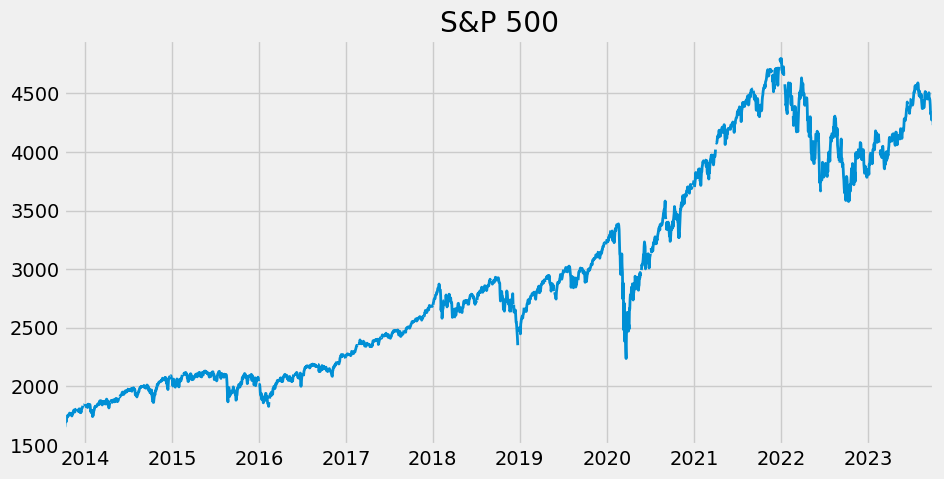

In [93]:
sp500 = fred.get_series('SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)

# 4. Pull and Join Multiple Data Series

In [94]:
unemp_df = fred.search("unemployment rate in", filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate in')]

In [95]:
all_results = []

for myid in unemp_df.index[:4]:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

unemp_results = pd.concat(all_results, axis=1)
unemp_results = unemp_results.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ' , '')[:4].to_dict()
unemp_results.columns=[id_to_state[c] for c in unemp_results.columns]

In [96]:
# Plot States Unemployment Rate
px.line(data_frame=unemp_results)

## Pull April 2020 Unemployment Rate Per State 

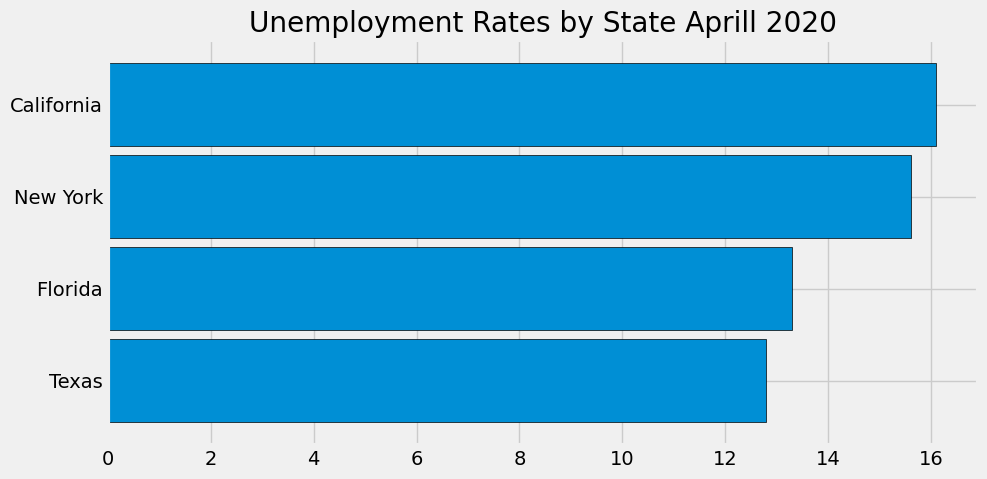

In [97]:
ax = unemp_results.loc[unemp_results.index == '2020-04-01'].T \
.sort_values('2020-04-01') \
.plot(kind='barh', figsize=(10,5),width=0.9,edgecolor='black',title='Unemployment Rates by State Aprill 2020')

ax.legend().remove()
plt.show()

# Pull Participation Rate

In [98]:
part_df = fred.search('participation rate state',filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df.loc[part_df['title'].str.contains('Participation Rate for')]


In [99]:
par_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

part_states = pd.concat(all_results, axis=1)
part_states.columns = [par_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation

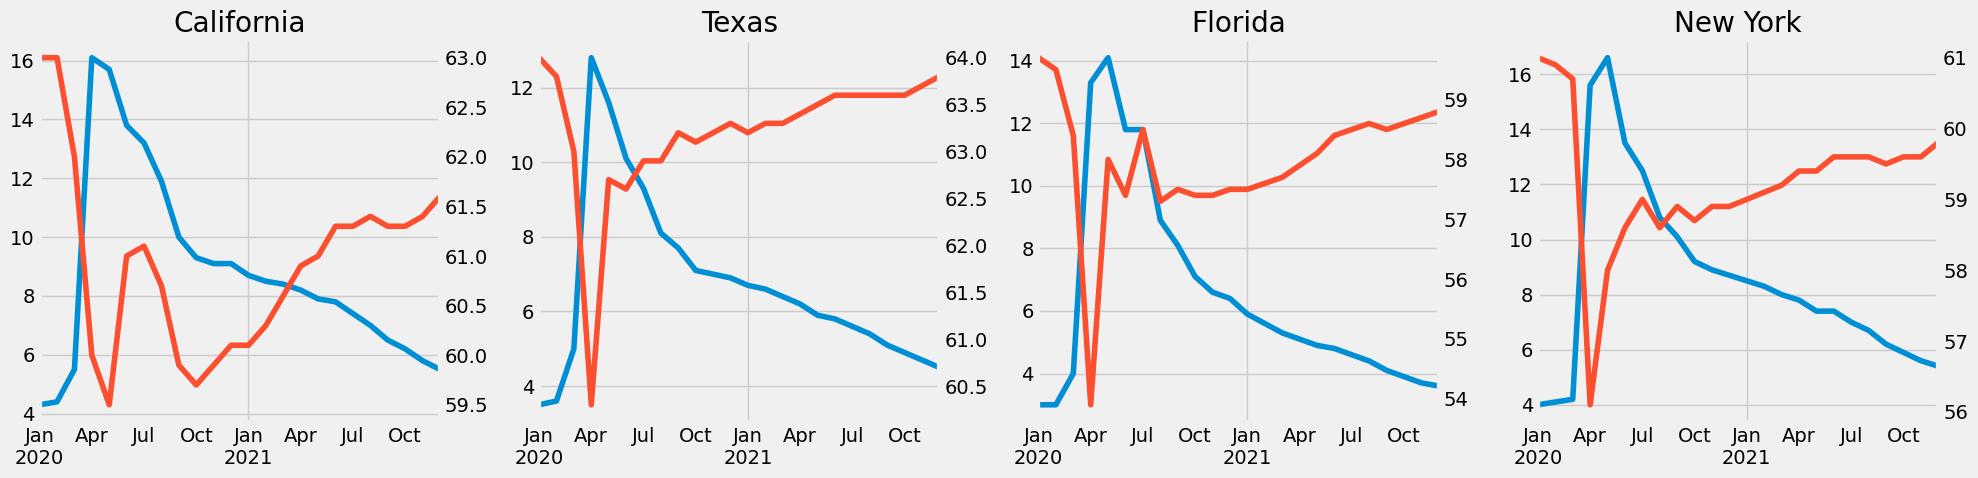

In [129]:
fig, axs = plt.subplots(1, 4, figsize=(20,5),sharex=True)
axs = axs.flatten()

i = 0
for state in unemp_results.columns:
    ax2 = axs[i].twinx()
    unemp_results.query('index >= 2020 and index < 2022')[state].plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state].plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()